# Multi-path Pathfinder Variational Inference

## Introduction

Pathfinder {cite:p}`zhang2021pathfinder` is a variational inference algorithm that produces samples from the posterior of a Bayesian model and compares favorably to the widely used ADVI algorithm. On large problems, it should scale better than most MCMC algorithms, including dynamic HMC (i.e., NUTS), and requires 1-2 orders of magnitude fewer log density and gradient evaluations than ADVI and dynamic HMC's warmup phase. Moreover, Pathfinder can perform the Monte Carlo KL divergence estimates used to compute ELBO in parallel, providing a major advantage over ADVI, which must evaluate the ELBO sequentially.

Like ADVI, the computational efficiencies may come at the cost of a more biased estimate of the posterior but can be managed through the algorithm's settings. For details on the algorithm, see the [arxiv preprint](https://arxiv.org/abs/2108.03782).

In this notebook, we will provide a high-level overview of the (single) Pathfinder algorithm, Multi-path Pathfinder algorithm, how to use it with PyMC, and discuss recommended changes to the algorithm's settings after validating the model fit.

### Pathfinder algorithm

To help with understanding the Pathfinder algorithm, we will group parts of the algorithm into the following components/steps:

1. Optimization trajectory
2. Normal approximations
3. Sampling from normal approximations
4. Evaluating ELBO
5. Posterior sampling


#### 1. Optimization trajectory 

Pathfinder uses L-BFGS in (#TODO: eq), a (deterministic) quasi-Newton optimization approach, to generate an optimisation trajectory and the evaluated gradients at each point along the trajectory:


$$
\theta^{(0:L)}, \nabla \log p (\theta^{(0:L)}) = \text{L-BFGS}(\log p, \theta^{(0)}, J, \tau^{\text{rel}}, L^{\text{max}}),
$$

where

- $\theta^{(0:L)}$ is the optimization trajectory
- $\nabla \log p (\theta^{})$ represents the evaluated gradients at each point along the trajectory
- $J$ is the history size
- $\tau^{\text{rel}}$ is the relative tolerance for convergence of L-BFGS
- $L^{\text{max}}$ is the maximum number of L-BFGS iterations
- $\theta^{(0)}$ is the initial point for L-BFGS
- $\log p$ is the log density function of the posterior distribution
- $L$ is the number of iterations to reach convergence

Starting from a random point at $\theta^{(0)}$, which should be at the tail-region of the posterior distribution, L-BFGS moves through the body of the distribution and towards a local maximum.

#### 2. Normal approximations

After obtaining an optimization trajectory and evaluated gradients, the next step is to construct (local) normal approximations at each point along the trajectory.

$$

$$ (#TODO: add equation)


We can denote the normal approximation at point as:


where $\mu^{(l)}$ and $\Sigma^{(l)}$ are the mean and covariance matrix of the normal approximation at point $\theta^{(l)}$.

The covariance matrix $\Sigma^{(l)}$ is derived from the computed inverse Hessian factors such that:

$$
\Sigma^{(l)} = \text{diag}(\alpha^{(l)}) + \beta \cdot \gamma \cdot \beta^T
$$

where $\alpha^{(l)}$ is the diagonal of the inverse Hessian factor at point $\theta^{(l)}$, $\beta$ and $\gamma$ are the matrix of the inverse Hessian factor. The factors form the low-rank plus diagonal factorization of the inverse Hessian factor. See {cite:t}`zhang2021pathfinder` for details on the formulas for $\alpha^{(l)}$, $\beta$, and $\gamma$.

Unlike ADVI, where the covariance matrix is either diagonal or full rank, Pathfinder uses a low-rank plus diagonal factorization of the inverse Hessian factor, where the rank is determined by the history size $J$.

#### 3. Sampling from normal approximations

The normal approximations using the factors from the inverse Hessian are used to generate Monte Carlo draws calculate ELBO. 

$$

$$ (#TODO: add equation)

These samples are then used to evaluate the ELBO for each approximation, allowing Pathfinder to identify the region of highest probability mass.


*this section is not yet finished*

Comparison summary of Pathfinder and ADVI

| VI               | Pathfinder                                                                     | ADVI                                                                       |
| --------------------- | ------------------------------------------------------------------------------ | -------------------------------------------------------------------------- |
| Optimization approach | Uses quasi-Newton methods to directly optimize the negative log target density | Performs stochastic gradient descent directly on the ELBO                  |
| Approximation type    | Low-rank plus diagonal factorizations                                          | Either diagonal (mean-field) or dense (full-rank)                          |
| Computation           | Parallel computation of log density, gradient, and ELBO                        | Sequential computation due to SGD optimization process                     |
| Curvature information | Uses local curvature information collected along the optimization trajectory   | Not used in mean-field ADVI, and full covariance matrix used in dense ADVI |
| Performance           | Requires fewer log density and gradient evaluations                            | Requires more evaluations                                                  |

### Application

PyMC's implementation of Pathfinder is now natively integrated using PyTensor. The Pathfinder implementation can be accessed through [pymc-extras](https://github.com/pymc-devs/pymc-extras/), which can be installed via:

`pip install git+https://github.com/pymc-devs/pymc-extras`

In [21]:
import os

import numpy as np
import pandas as pd
import pymc as pm
import pymc_extras as pmx
import pytensor.tensor as pt
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import default_rng
from copy import copy

# configure matplotlib
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.figsize": (6, 3.3),
        "axes.edgecolor": "black",
        "axes.linewidth": 0.35,
        "axes.facecolor": "white",
        "font.size": 8,
        "lines.linewidth": 0.9,
        "lines.markersize": 4,
        "lines.markeredgecolor": "k",
        "lines.markeredgewidth": 0.6,
    }
)

# set arviz style
az.style.use("arviz-darkgrid")

In [22]:
pmx.__version__

'0.2.4'

In [23]:
def plot_results(results, plot_arviz=False, var_names=None, **plot_kwargs):
    if isinstance(results, dict):
        results_az_dict = {
            key: az.extract(value, var_names=var_names, keep_dataset=True)
            for key, value in results.items()
        }
    else:
        results_az_dict = {"results": az.extract(results)}
        results = {"results": results}

    num_subplots = 0
    for key, results_az in results_az_dict.items():
        for var_name, var_data in results_az.data_vars.items():
            dims = var_data.dims
            if dims == ("sample",):
                num_subplots += 1
            else:
                coord_names = var_data.coords[dims[0]].values
                num_subplots += len(coord_names)
        break

    ncols = min(5, num_subplots)
    nrows = (num_subplots + ncols - 1) // ncols
    figsize = (ncols * 3.3, nrows * 3.1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if isinstance(axes, np.ndarray):
        ax = axes.flat
    else:
        ax = [axes]

    default_kwargs = {"fill": True, "alpha": 0.35, "linewidth": 1}
    plot_kwargs = default_kwargs | plot_kwargs

    for key, results_az in results_az_dict.items():
        i = 0
        for var_name, var_data in results_az.data_vars.items():
            dims = var_data.dims
            if len(dims) == 1:
                sns.kdeplot(
                    var_data.data.ravel(),
                    ax=ax[i],
                    **plot_kwargs,
                )
                ax[i].set_title(var_name)
                i += 1
            else:
                for dim in dims:
                    if dim != "sample":
                        coord_names = var_data.coords[dim].values
                        for coord_name in coord_names:
                            data = var_data.loc[{dim: coord_name}].data
                            sns.kdeplot(
                                data.ravel(),
                                ax=ax[i],
                                **plot_kwargs,
                            )
                            ax[i].set_title(f"{var_name}[{coord_name}]")
                            i += 1

    handles = []
    for c, (key, results_az) in enumerate(results_az_dict.items()):
        handles.append(
            plt.Line2D(
                [0],
                [0],
                color=sns.color_palette()[c],
                lw=4,
                label=f"(sns): {key}",
                alpha=0.5,
            )
        )
        if plot_arviz:
            try:
                az.plot_density(
                    results[key],
                    var_names=list(results_az.data_vars.keys()),
                    colors="k",
                    shade=0.15,
                    textsize=8,
                    ax=ax,
                )
                handles.append(
                    plt.Line2D(
                        [0], [0], color="k", lw=4, label=f"(arviz): {key}", alpha=0.5
                    )
                )
            except Exception as e:
                print(f"ArviZ plotting failed: {str(e)}")

    # create a single legend at the bottom outside the axes
    fig.legend(
        handles=handles,
        loc="lower center",
        ncol=len(handles),
        bbox_to_anchor=(0.5, -0.15),
        fontsize=20,
    )

    for axis in ax:
        axis.set_ylabel("")
        axis.set_yticks([])
        axis.set_yticklabels([])

    for j in range(i, len(ax)):
        ax[j].axis("off")

    plt.show()

## Eight Schools example

In [24]:
def eight_schools_model():
    J = 8
    y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
    sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0.0, sigma=10.0)
        tau = pm.HalfCauchy("tau", 5.0)

        theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
        obs = pm.Normal("obs", mu=mu + tau * theta, sigma=sigma, shape=J, observed=y)

    return model


model = eight_schools_model()

In [25]:
with model:
    pmx.fit(method="pathfinder", progressbar=False, inference_backend="pymc")

ModuleNotFoundError: No module named 'jax.numpy'

In [26]:
import jax
import jax.numpy as jnp

ModuleNotFoundError: No module named 'jax.numpy'

In [66]:
with model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder", random_seed=41)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Finished [100%]: Average Loss = 31.852
Number of parameters: 10
Setting maxcor to 7
Pareto k value: 0.84


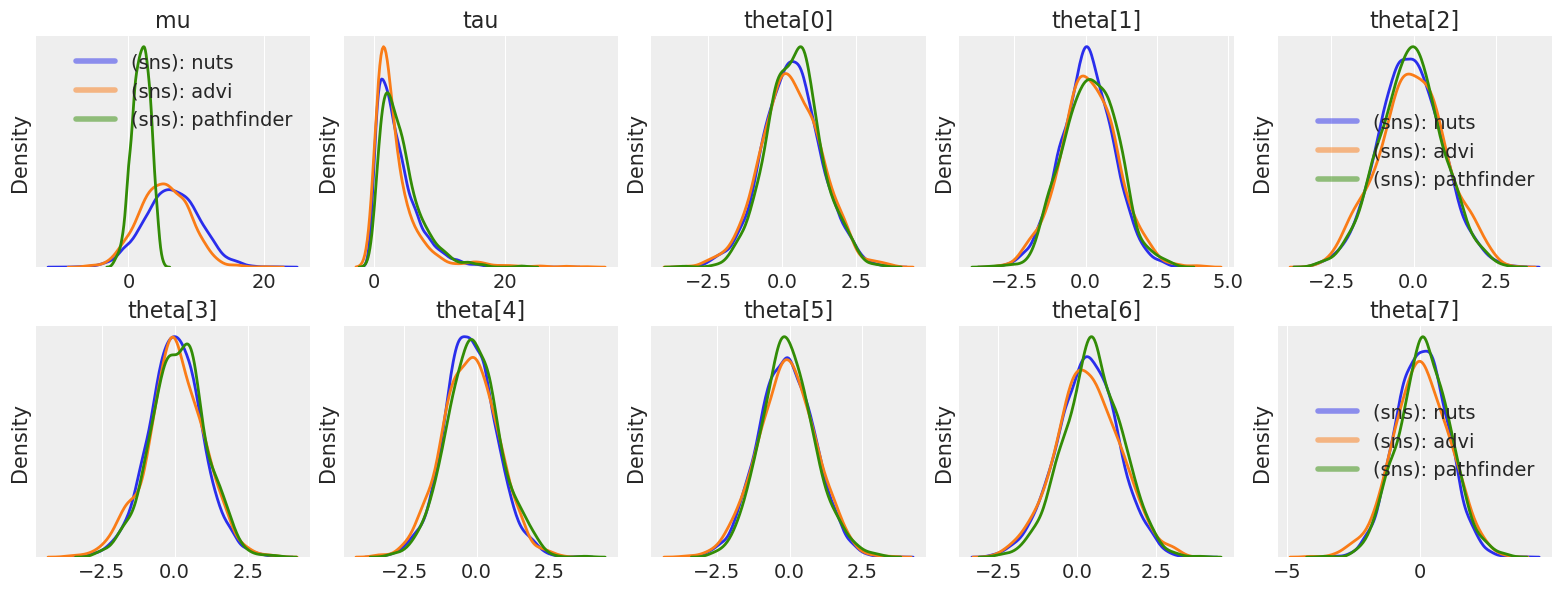

In [67]:
res = {"nuts": idata_nuts, "advi": idata_advi, "pathfinder": idata_pf}
plot_results(res, fill=False, linewidth=2, alpha=1)

In [68]:
with model:
    idata_jitter_pf = pmx.fit(
        method="pathfinder",
        jitter=10.0,
        random_seed=41,
    )

    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder",
        num_paths=50,
        jitter=10.0,
        random_seed=41,
    )

Number of parameters: 10
Setting maxcor to 7


Pareto k value: 1.09
Number of parameters: 10
Setting maxcor to 7
Pareto k value: 0.99


The small mu value (approx 1.5) for pathfinder with the default jitter of 2.0 is consistent with the results of Stan's multipath Pathfinder fit.

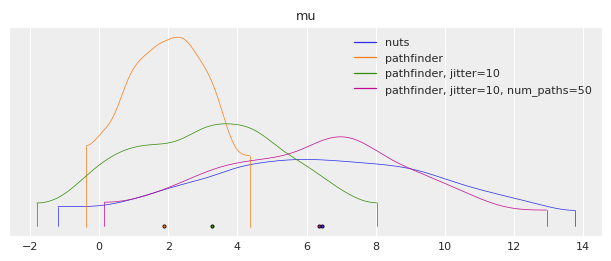

In [69]:
az.plot_density(
    [idata_nuts, idata_pf, idata_jitter_pf, idata_jitter_paths_pf],
    data_labels=[
        "nuts",
        "pathfinder",
        "pathfinder, jitter=10",
        "pathfinder, jitter=10, num_paths=50",
    ],
    var_names=["mu"],
    figsize=(6, 2.5),
    textsize=8,
);

In [70]:
az.summary(idata_jitter_paths_pf)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,6.359,3.380,0.142,12.947,0.107,0.075,1005.0,981.0,NaN
tau,3.051,3.023,0.009,8.484,0.095,0.067,1024.0,983.0,NaN
theta[0],0.225,0.982,-1.587,2.089,0.028,0.022,1245.0,911.0,NaN
theta[1],0.037,0.891,-1.503,1.913,0.033,0.023,726.0,854.0,NaN
theta[2],-0.163,0.977,-1.947,1.613,0.030,0.023,1083.0,912.0,NaN
theta[3],-0.017,0.915,-1.731,1.588,0.030,0.021,954.0,982.0,NaN
theta[4],-0.160,0.952,-1.790,1.773,0.030,0.021,996.0,850.0,NaN
theta[5],-0.122,0.914,-1.843,1.535,0.031,0.022,894.0,952.0,NaN
theta[6],0.328,0.956,-1.490,2.080,0.030,0.021,1044.0,932.0,NaN
theta[7],0.083,0.923,-1.609,1.851,0.029,0.020,1021.0,1021.0,NaN


In [71]:
with model:
    idata_no_importance_sampling = pmx.fit(
        method="pathfinder",
        num_paths=50,
        random_seed=41,
        importance_sampling="none",
    )

Number of parameters: 10
Setting maxcor to 7


importance sampling is disabled. The samples are returned as is which may include samples from failed paths with non-finite logP or logQ values. It is recommended to use importance_sampling='psis' for better stability.


Without importance sampling, and although it is not recommended, it is now possible to compute r_hat. r_hat should not be a diagnostic measure for a model fitted with Pathfinder as each path can, and is expected to, exploit different regions of the posterior. So the between path (or chain) variance is expected to be large. The region in which a path exploits may be sensitive to the jitter scale used to randomise the initialisation of the path.

It is, therefore, recommended to use importance sampling because it is possible for a path or subset of paths to exploit a region of the posterior that can be far away from the posterior mean. Importance sampling assigns importance weights to each sample to make new random draws, and so reduces the variance of the collective samples from all paths and the resulting samples are likely to reflect the true posterior.


In [72]:
az.summary(idata_no_importance_sampling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.488,2.683,-2.293,4.930,0.177,0.149,127.0,147.0,1.29
tau,11.871,23.921,0.202,37.746,1.666,1.180,129.0,258.0,1.29
theta[0],0.487,0.849,-1.177,2.057,0.024,0.017,1309.0,2629.0,1.02
theta[1],0.232,0.827,-1.394,1.794,0.013,0.019,4277.0,4484.0,1.05
theta[2],-0.090,0.833,-1.681,1.507,0.004,0.017,44376.0,5268.0,1.03
theta[3],0.157,0.828,-1.415,1.782,0.011,0.018,5435.0,4642.0,1.04
theta[4],-0.070,0.820,-1.633,1.543,0.010,0.020,6060.0,3237.0,1.06
theta[5],0.004,0.824,-1.608,1.563,0.013,0.019,4285.0,3982.0,1.05
theta[6],0.588,0.820,-1.000,2.167,0.021,0.018,1514.0,2024.0,1.05
theta[7],0.150,0.834,-1.467,1.726,0.005,0.016,25166.0,5058.0,1.03


## Rugby example - Hierarchical Poisson Regression

https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html

In [73]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

In [74]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [75]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )

In [76]:
with model:
    print("Starting NUTS fit...")
    %timeit pm.sample(1000, tune=1500, cores=4, progressbar=False)
    print("\nStarting ADVI fit...")
    %timeit pm.fit(n=30_000, progressbar=False).sample(1000)
    print("\nStarting Pathfinder fit...")
    %timeit pmx.fit(method="pathfinder")

Starting NUTS fit...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 10 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 9 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) too

9.7 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 557.61
Finished [100%]: Average Loss = 557.48
Finished [100%]: Average Loss = 557.67
Finished [100%]: Average Loss = 557.52
Finished [100%]: Average Loss = 557.58
Finished [100%]: Average Loss = 557.66
Finished [100%]: Average Loss = 557.54
Finished [100%]: Average Loss = 557.51
Number of parameters: 16
Setting maxcor to 9


5.87 s ± 55.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Starting Pathfinder fit...


Pareto k value: 0.92
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 1.04
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 0.84
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 0.86
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 0.94
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 1.10
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 1.19
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 0.94


4.74 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
with model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 9 seconds.
Finished [100%]: Average Loss = 557.48
Number of parameters: 16
Setting maxcor to 9
Pareto k value: 0.90


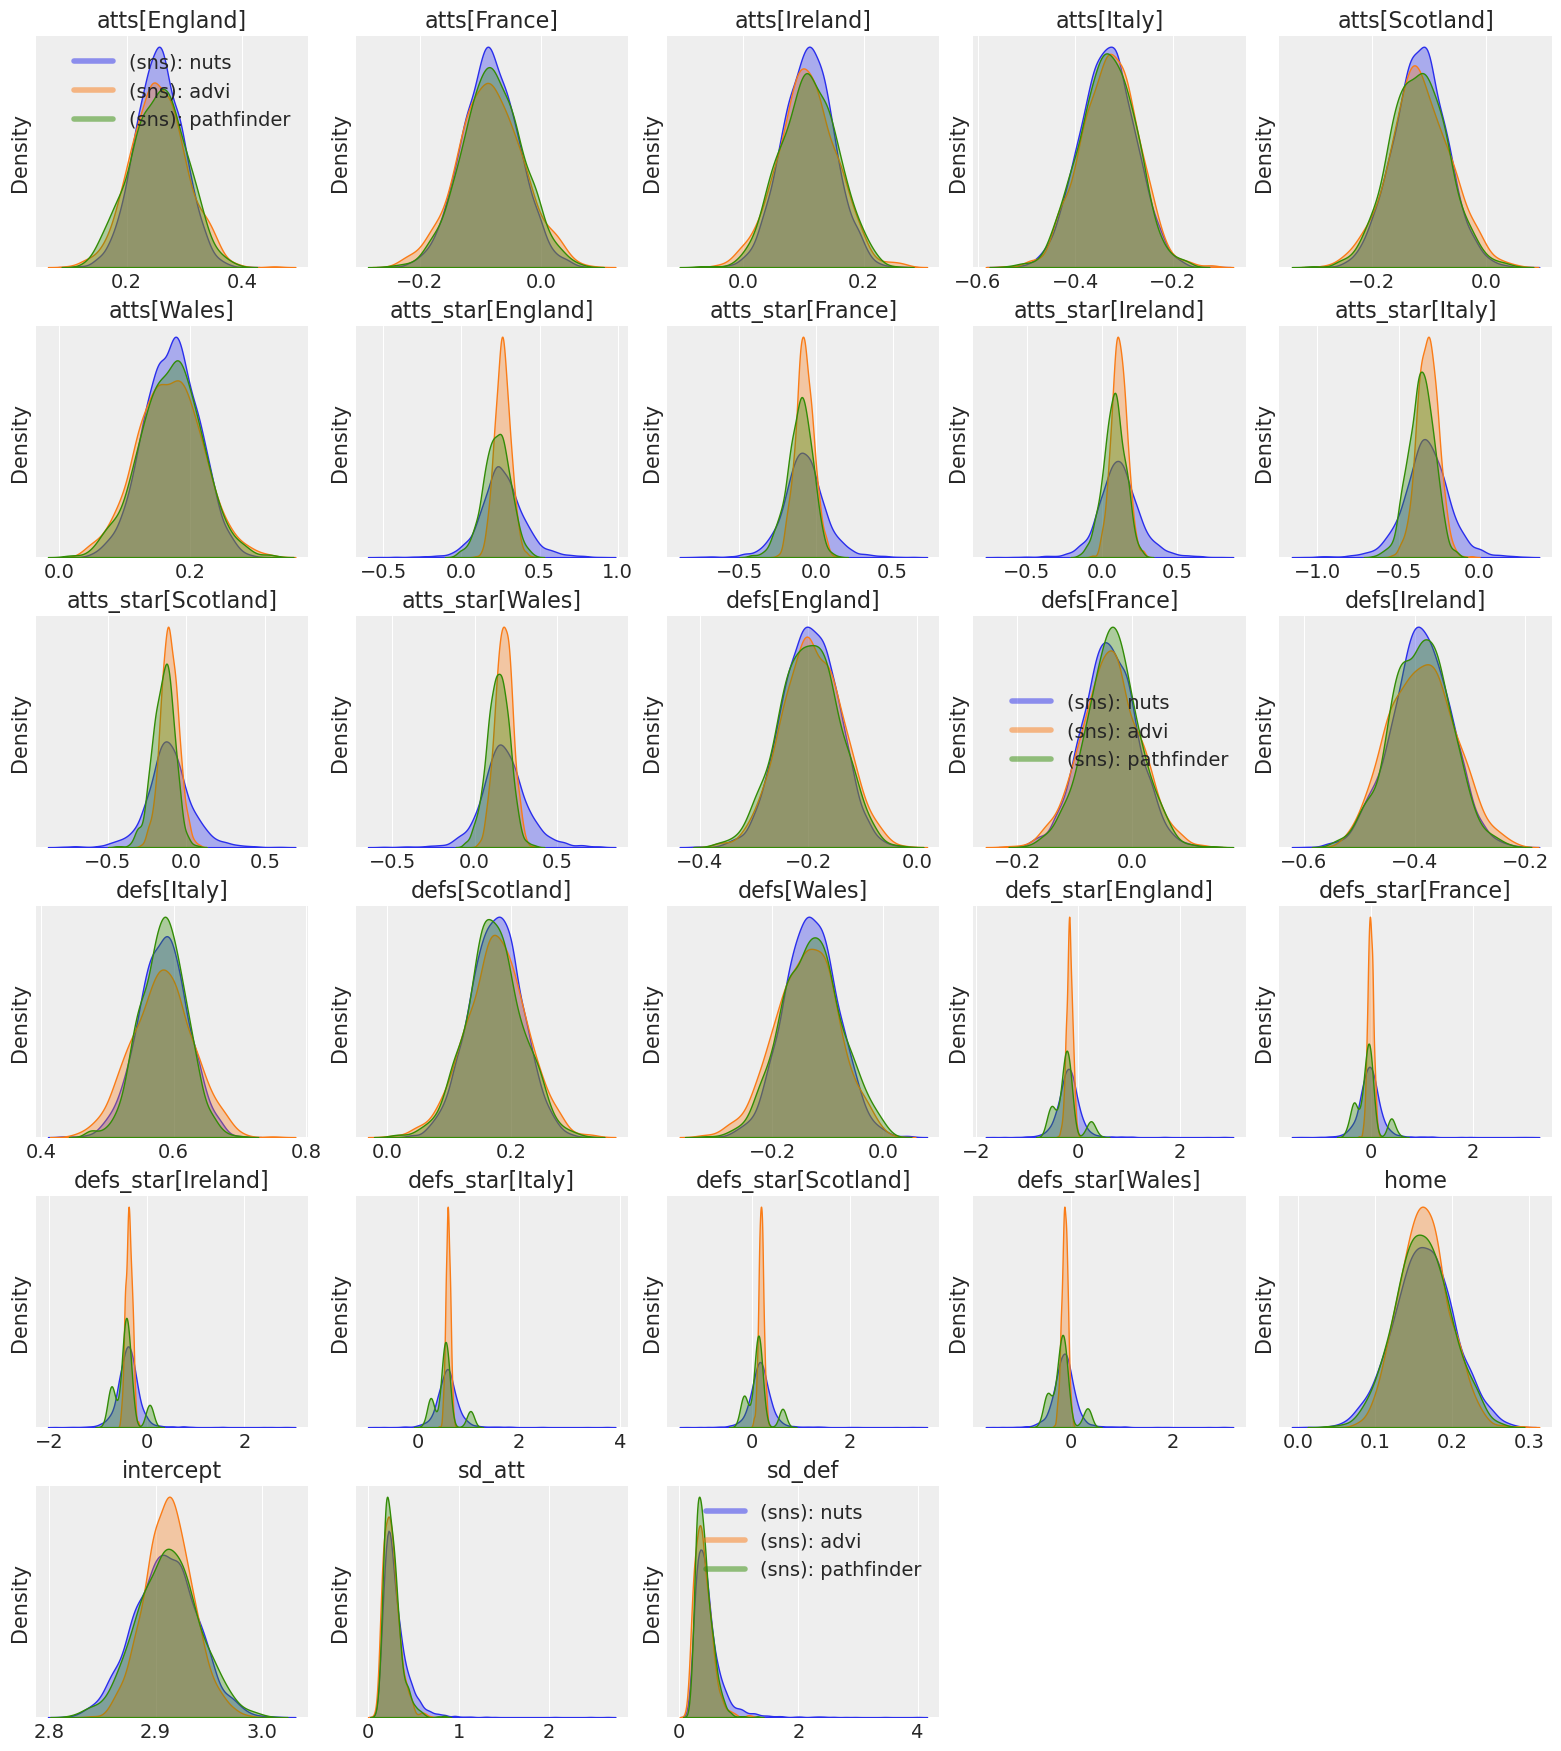

In [78]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res)

## Cherry Blossoms - Spline Regression

In [79]:
from patsy import dmatrix
from pathlib import Path

RANDOM_SEED = 8927

In [80]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)

In [81]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

In [82]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)

In [83]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

In [84]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=blossom_data.doy)

In [85]:
with spline_model:
    print("Starting NUTS fit...")
    %timeit -r 5 pm.sample(1000, tune=1000, cores=4, progressbar=False)
    print("\nStarting ADVI fit...")
    %timeit -r 5 pm.fit(n=30_000, progressbar=False).sample(1000)
    print("\nStarting Pathfinder fit...")
    %timeit -r 5 pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...


Starting NUTS fit...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4

4.81 s ± 63.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 2,681.8
Finished [100%]: Average Loss = 2,681.9
Finished [100%]: Average Loss = 2,681.9
Finished [100%]: Average Loss = 2,682
Finished [100%]: Average Loss = 2,681.8
Finished [100%]: Average Loss = 2,682
Number of parameters: 19
Setting maxcor to 9


3.58 s ± 36.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting Pathfinder fit...


Pareto k value: 1.33
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.43
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.49
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.15
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.24
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.14


3.75 s ± 71.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [86]:
with spline_model:
    idata_nuts = pm.sample(1000, tune=1000, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Finished [100%]: Average Loss = 2,681.9
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.07


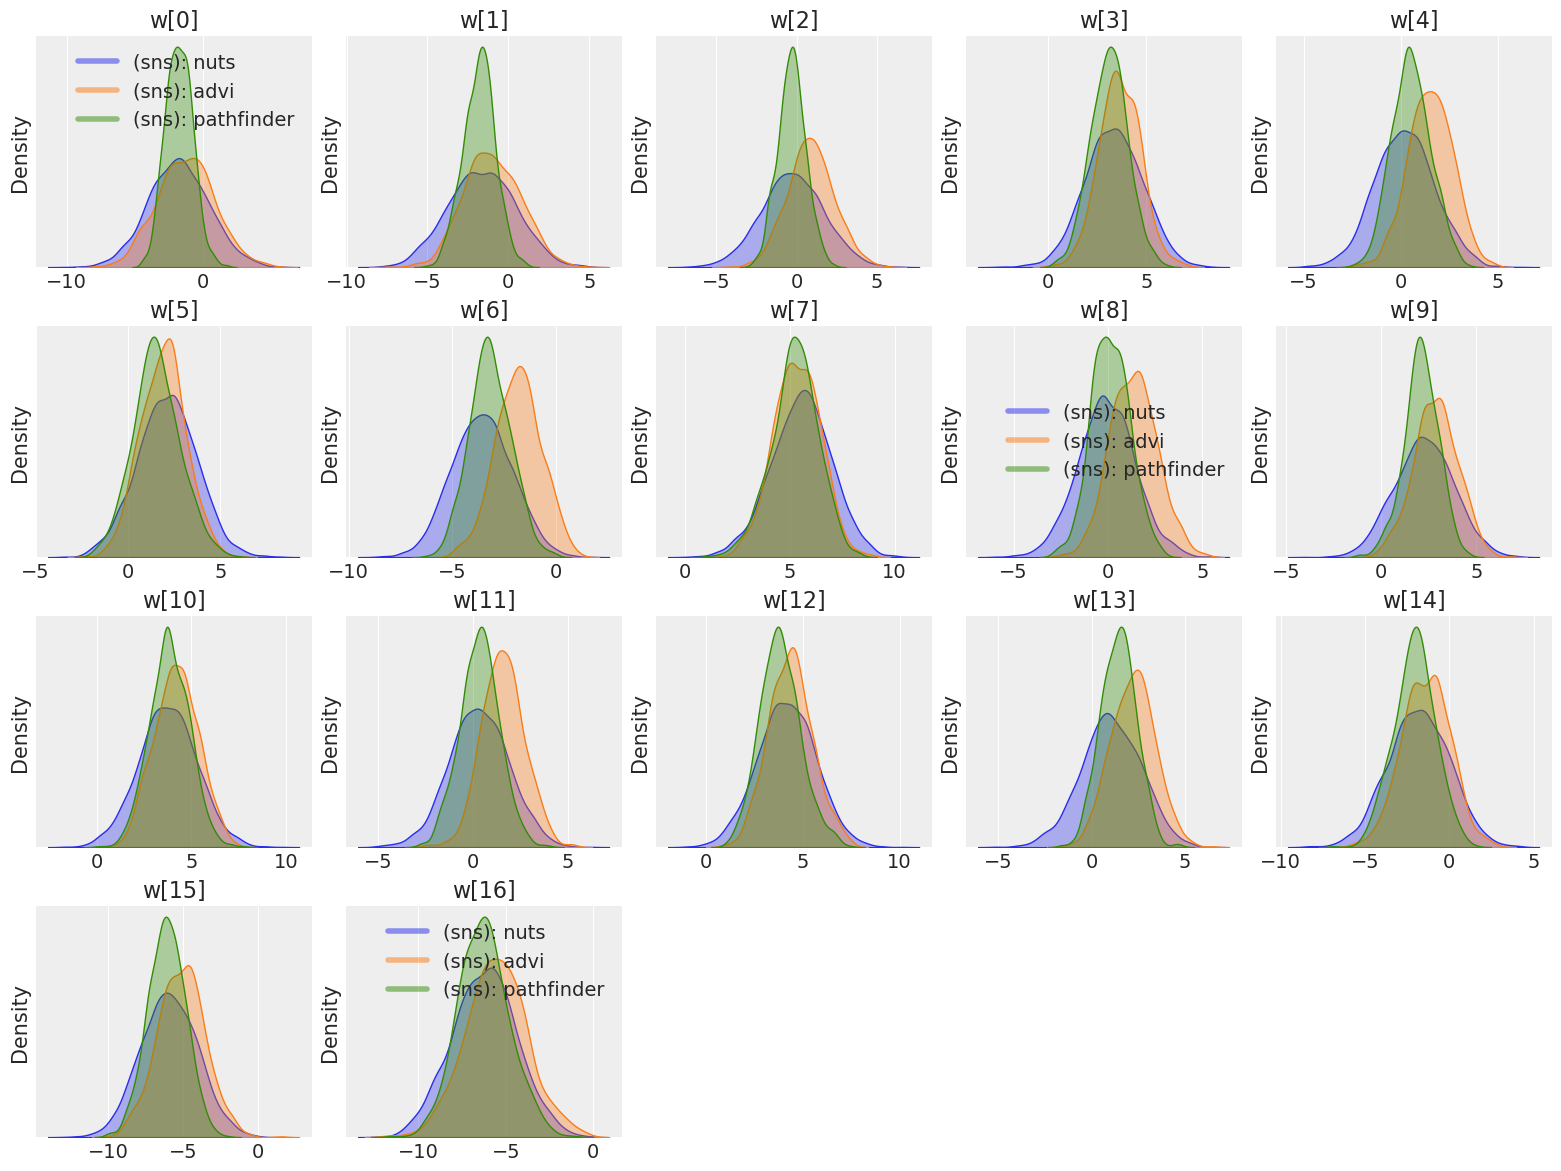

In [89]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res, var_names=["w"])

Pathfinder appears to underestimate the variance for some of the spline weights. Not to worry, we can increase the jitter and number of paths to help with this.

In [90]:
with spline_model:
    idata_jitter_pf = pmx.fit(method="pathfinder", jitter=20.0, random_seed=41)
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=41
    )
    idata_jitter_paths_maxcor_pf = pmx.fit(
        method="pathfinder", maxcor=25, jitter=20.0, num_paths=50, random_seed=41
    )

Number of parameters: 19
Setting maxcor to 9


Pareto k value: 0.90
Number of parameters: 19
Setting maxcor to 9
Pareto k value: 1.03
Number of parameters: 19
Pareto k value: 1.10


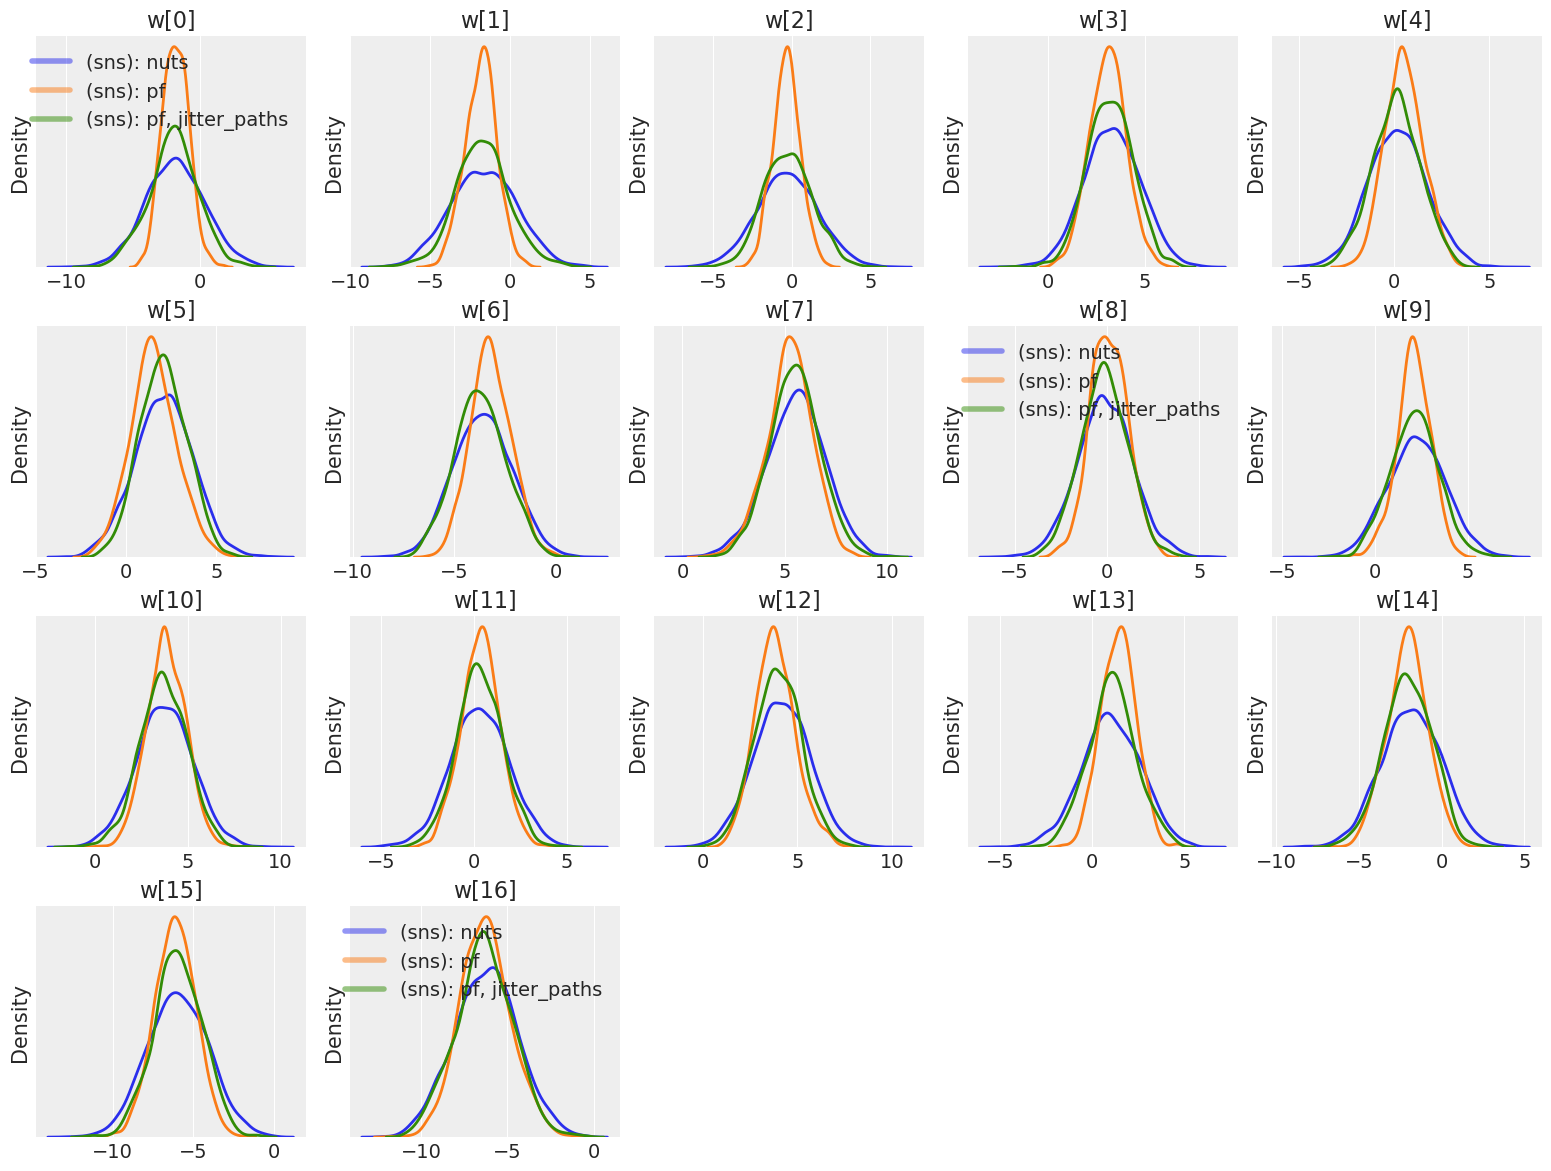

In [108]:
res = {
    "nuts": idata_nuts,
    "pf": idata_pf,
    # "pf, jitter": idata_jitter_pf,
    "pf, jitter_paths": idata_jitter_paths_pf,
    # "pf, jitter_paths_maxcor": idata_jitter_paths_maxcor_pf,
}
plot_results(res, var_names=["w"], fill=False, linewidth=2, alpha=1)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

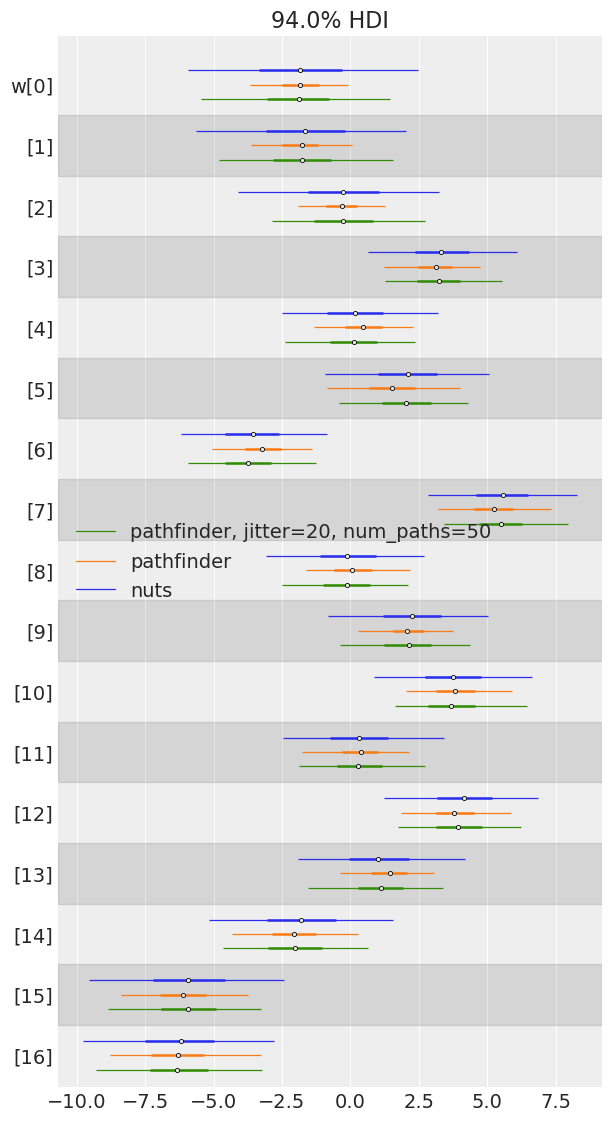

In [121]:
az.plot_forest(
    [idata_nuts, idata_pf, idata_jitter_paths_pf],
    model_names=["nuts", "pathfinder", "pathfinder, jitter=20, num_paths=50"],
    var_names=["w"],
    combined=True,
)

## Truncated and Censored Regression example

In [122]:
rng = default_rng(12345)
slope, intercept, sigma, N = 1, 0, 2, 200
x = rng.uniform(-10, 10, N)
y = rng.normal(loc=slope * x + intercept, scale=sigma)


def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])


def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)

In [123]:
bounds = [-5, 5]
xt, yt = truncate_y(x, y, bounds)
xc, yc = censor_y(x, y, bounds)

In [124]:
def linear_regression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("σ", sigma=1)
        pm.Normal("obs", mu=slope * x + intercept, sigma=sigma, observed=y)

    return model


trunc_linear_model = linear_regression(xt, yt)

In [125]:
with trunc_linear_model:
    print("Starting NUTS fit...")
    %timeit -r 5 pm.sample(1000, tune=1500, cores=4, progressbar=False)
    print("\nStarting ADVI fit...")
    %timeit -r 5 pm.fit(n=30_000, progressbar=False).sample(1000)
    print("\nStarting Pathfinder fit...")
    %timeit -r 5 pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...


Starting NUTS fit...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw itera

2.24 s ± 109 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 198.53
Finished [100%]: Average Loss = 198.5
Finished [100%]: Average Loss = 198.53
Finished [100%]: Average Loss = 198.52
Finished [100%]: Average Loss = 198.51
Finished [100%]: Average Loss = 198.52
Number of parameters: 3
Setting maxcor to 5


3.2 s ± 37.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting Pathfinder fit...


Pareto k value: 0.66
Number of parameters: 3
Setting maxcor to 5
Pareto k value: 0.37
Number of parameters: 3
Setting maxcor to 5
Pareto k value: 0.42
Number of parameters: 3
Setting maxcor to 5
Pareto k value: 0.27
Number of parameters: 3
Setting maxcor to 5
Pareto k value: 0.49
Number of parameters: 3
Setting maxcor to 5
Pareto k value: 0.52


3.6 s ± 32.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [126]:
with trunc_linear_model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2 seconds.
Finished [100%]: Average Loss = 198.51
Number of parameters: 3
Setting maxcor to 5
Pareto k value: 0.35


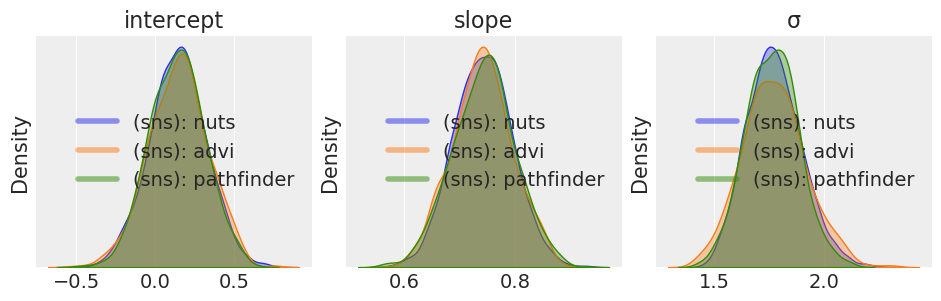

In [127]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res)

## Radon household example - Hierarchical Linear Regression

In [128]:
try:
    data = pd.read_csv(os.path.join("..", "data", "radon.csv"))
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("radon.csv"))

In [129]:
county_idx = data["county_code"].values
floor_idx = data["floor"].values
log_radon_idx = data["log_radon"].values

coords = {"counties": data.county.unique()}

In [130]:
with pm.Model(coords=coords) as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=100**2)
    sigma_a = pm.Uniform("sigma_alpha", lower=0, upper=100)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=100**2)
    sigma_b = pm.Uniform("sigma_beta", lower=0, upper=100)

    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="counties")
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="counties")

    radon_est = a[county_idx] + b[county_idx] * floor_idx

    # Model error
    eps = pm.Uniform("eps", lower=0, upper=100)

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like",
        mu=radon_est,
        sigma=eps,
        observed=log_radon_idx,
    )

In [131]:
log_radon_idx_t = pm.Minibatch(log_radon_idx, batch_size=100)
floor_idx_t = pm.Minibatch(floor_idx, batch_size=100)
county_idx_t = pm.Minibatch(county_idx, batch_size=100)

In [132]:
with pm.Model(coords=coords) as mb_hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=100**2)
    sigma_a = pm.Uniform("sigma_alpha", lower=0, upper=100)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=100**2)
    sigma_b = pm.Uniform("sigma_beta", lower=0, upper=100)

    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="counties")
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="counties")

    radon_est = a[county_idx_t] + b[county_idx_t] * floor_idx_t

    # Model error
    eps = pm.Uniform("eps", lower=0, upper=100)

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like",
        mu=radon_est,
        sigma=eps,
        observed=log_radon_idx_t,
        total_size=len(data),
    )

In [133]:
with hierarchical_model:
    print("Starting NUTS fit...")
    %timeit -r 5 pm.sample(1000, tune=1500, cores=4, progressbar=False)

with mb_hierarchical_model:
    print("\nStarting ADVI fit...")
    %timeit -r 5 pm.fit(n=30_000, progressbar=False).sample(1000)

with hierarchical_model:
    print("\nStarting Pathfinder fit...")
    %timeit -r 5 pmx.fit(method="pathfinder")

Starting NUTS fit...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, eps]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 12 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, eps]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 11 seconds.
There were 84 divergences after tuning. Increase `ta

13.2 s ± 738 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 152.1
Finished [100%]: Average Loss = 151.75
Finished [100%]: Average Loss = 151.5
Finished [100%]: Average Loss = 151.5
Finished [100%]: Average Loss = 151.83
Finished [100%]: Average Loss = 151.8
Number of parameters: 175
Setting maxcor to 16


13.6 s ± 310 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting Pathfinder fit...


Pareto k value: 4.48
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 3.52
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 3.20
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 5.10
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 4.71
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 4.40


6.47 s ± 447 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [134]:
with hierarchical_model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)

with mb_hierarchical_model:
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)

with hierarchical_model:
    idata_psir_pf = pmx.fit(
        method="pathfinder", importance_sampling="psir", random_seed=412
    )
    idata_pf = pmx.fit(method="pathfinder", random_seed=412)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, eps]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 11 seconds.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Finished [100%]: Average Loss = 152.38
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 3.98
Number of parameters: 175
Setting maxcor to 16
Pareto k value: 3.98


This was the point when I realised that the PSIR importance sampling was problematic! So I have made the default importance sampling to PSIS.


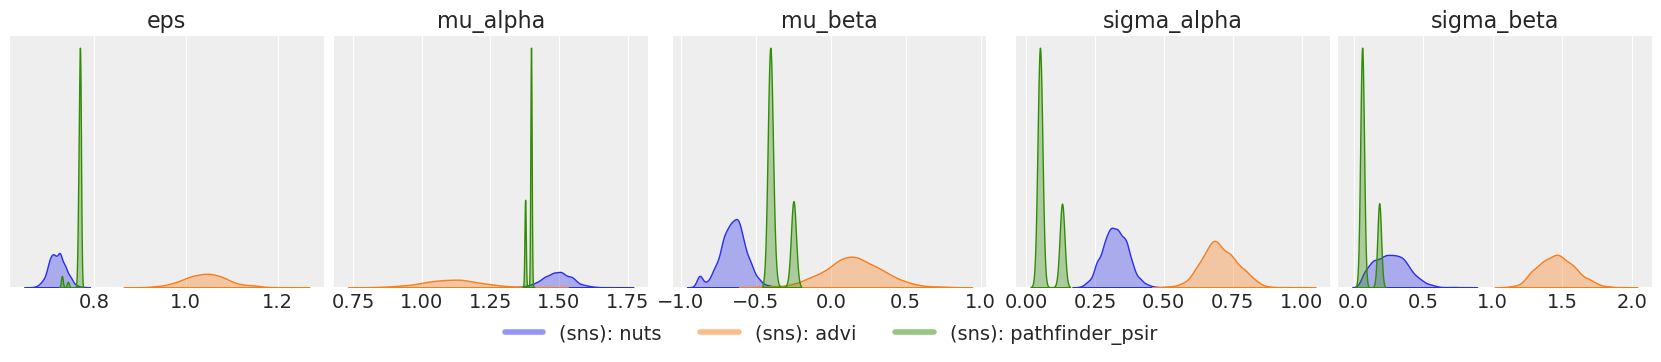

In [156]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    # "pathfinder": idata_pf,
    "pathfinder_psir": idata_psir_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Compared to PSIS, you don't get the extreme peaks like PSIR does.

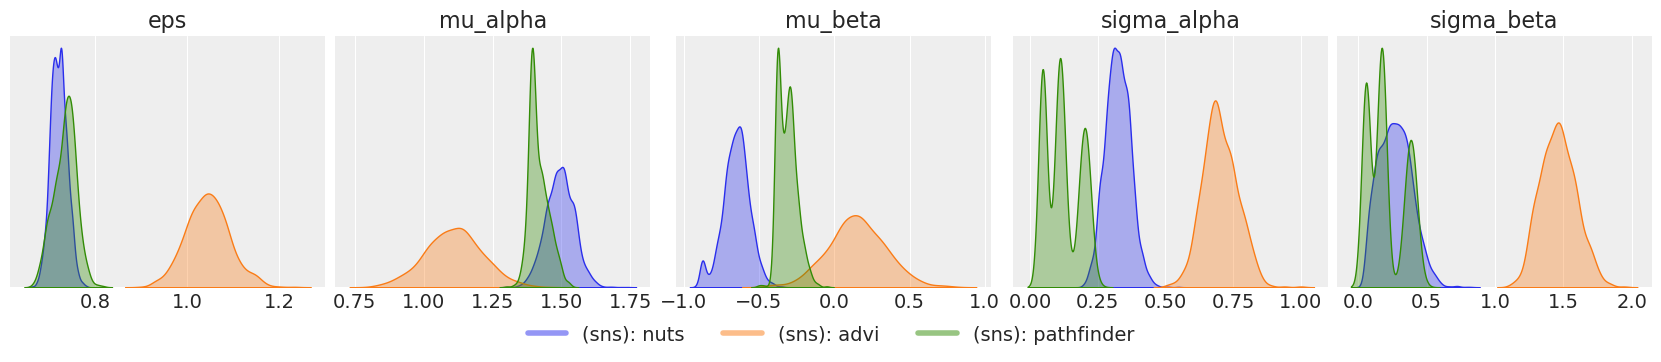

In [158]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
    # "pathfinder_psir": idata_psir_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Number of parameters: 175
Setting maxcor to 16
Pareto k value: 4.68


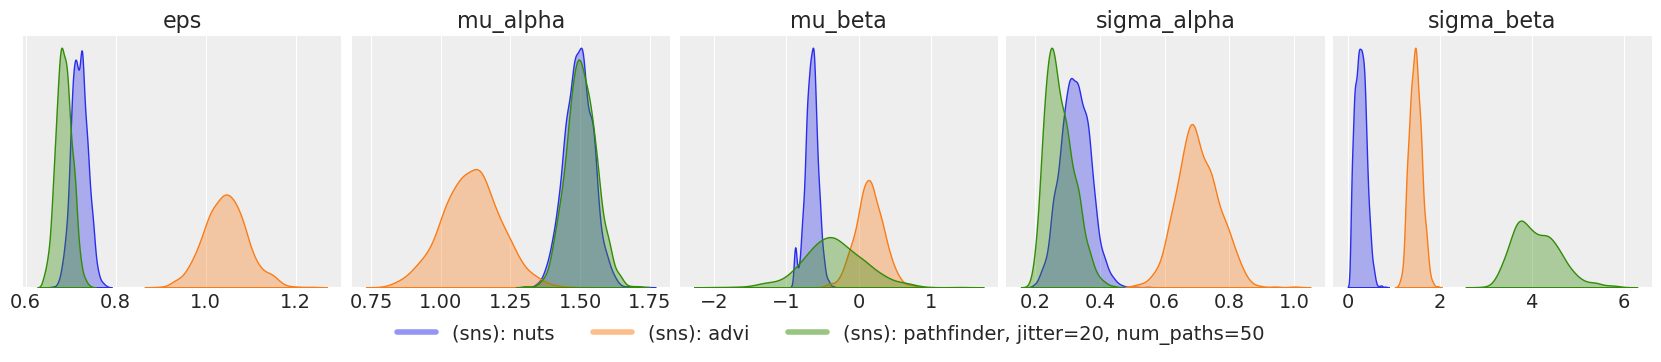

In [162]:
with hierarchical_model:
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=412
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=20, num_paths=50": idata_jitter_paths_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Number of parameters: 175
Setting maxcor to 16
Number of paths failed to sample: 2 out of 50
Pareto k value: 4.72


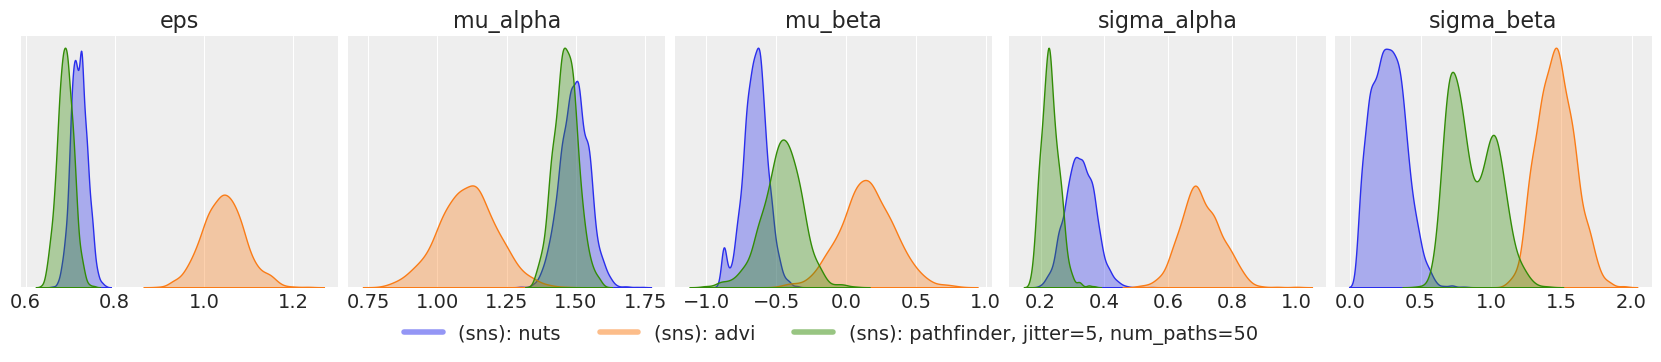

In [161]:
with hierarchical_model:
    idata_jitter_paths_pf2 = pmx.fit(
        method="pathfinder", jitter=5.0, num_paths=50, random_seed=412
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=5, num_paths=50": idata_jitter_paths_pf2,
}
plot_results(res, var_names=["~alpha", "~beta"])

Number of parameters: 175
Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86


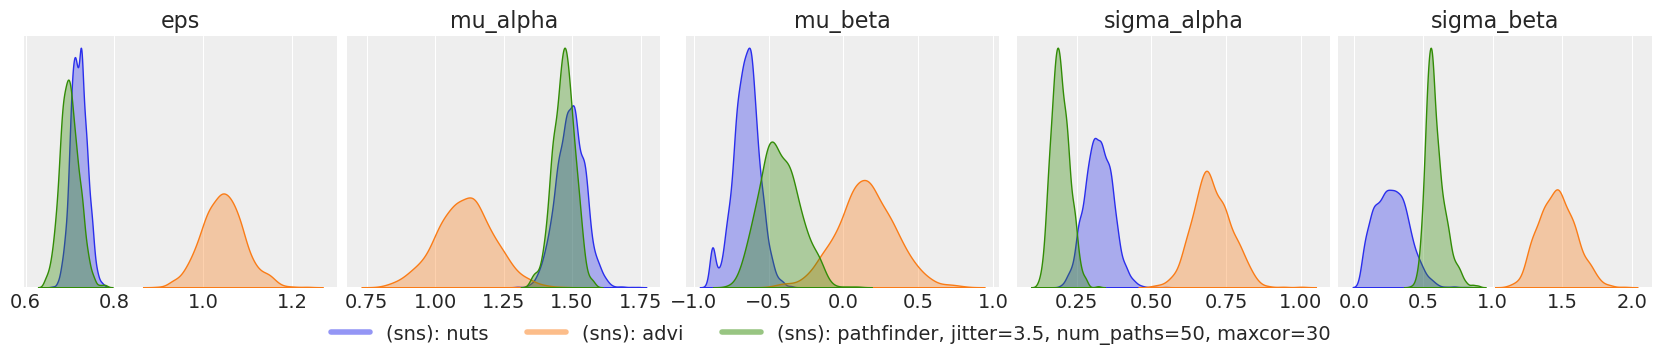

In [165]:
with hierarchical_model:
    idata_jitter_maxcor_paths_pf = pmx.fit(
        method="pathfinder", maxcor=30, jitter=3.5, num_paths=50, random_seed=412
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=3.5, num_paths=50, maxcor=30": idata_jitter_maxcor_paths_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Setting a high number of paths relative to the parameter space can result in a pointier posterior as you can see in sigma_beta and it gets worse with PSIR.

In [166]:
with hierarchical_model:
    print("\nStarting Pathfinder fit... no concurrency")
    %timeit -r 2 pmx.fit(method="pathfinder", maxcor=30, jitter=3.5, num_paths=50, random_seed=412)
    print("\nStarting Pathfinder fit... with concurrent=thread")
    %timeit -r 2 pmx.fit(method="pathfinder", maxcor=30, jitter=3.5, num_paths=50, random_seed=412, concurrent="thread")

Number of parameters: 175



Starting Pathfinder fit... no concurrency


Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86
Number of parameters: 175
Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86
Number of parameters: 175
Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86
Number of parameters: 175


40.8 s ± 6.37 s per loop (mean ± std. dev. of 2 runs, 1 loop each)

Starting Pathfinder fit... with concurrent=thread


Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86
Number of parameters: 175
Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86
Number of parameters: 175
Number of paths failed to sample: 1 out of 50
Pareto k value: 4.86


42 s ± 972 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


## Mixture Model example

In [5]:
import scipy

rng = np.random.default_rng(12345)

true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
trees = ["pine", "oak", "ebony", "rosewood", "mahogany"]  # Tree species observed
# fmt: off
forests = [  # Forests observed
    "sunderbans", "amazon", "arashiyama", "trossachs", "valdivian",
    "bosc de poblet", "font groga", "monteverde", "primorye", "daintree",
]
# fmt: on
k = len(trees)
n = len(forests)
total_count = 50

true_p = scipy.stats.dirichlet(true_conc * true_frac).rvs(size=n, random_state=rng)
observed_counts = np.vstack(
    [
        scipy.stats.multinomial(n=total_count, p=p_i).rvs(random_state=rng)
        for p_i in true_p
    ]
)

In [6]:
coords = {"tree": trees, "forest": forests}
with pm.Model(coords=coords) as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    counts = pm.Multinomial(
        "counts",
        n=total_count,
        p=frac,
        observed=observed_counts,
        dims=("forest", "tree"),
    )

In [169]:
with model_multinomial:
    print("Starting NUTS fit...")
    %timeit -r 5 pm.sample(1000, tune=1000, cores=4, progressbar=False)

    print("\nStarting ADVI fit...")
    %timeit -r 5 pm.fit(n=30_000, progressbar=False).sample(1000)

    print("\nStarting Pathfinder fit...")
    %timeit -r 5 pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...


Starting NUTS fit...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Initializing NUTS using j

3.13 s ± 41.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 135.25
Finished [100%]: Average Loss = 135.17
Finished [100%]: Average Loss = 135.24
Finished [100%]: Average Loss = 135.22
Finished [100%]: Average Loss = 135.24
Finished [100%]: Average Loss = 135.21
Number of parameters: 4
Setting maxcor to 5


4.25 s ± 26.9 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting Pathfinder fit...


Pareto k value: 0.83
Number of parameters: 4
Setting maxcor to 5
Pareto k value: 0.74
Number of parameters: 4
Setting maxcor to 5
Pareto k value: 0.66
Number of parameters: 4
Setting maxcor to 5
Pareto k value: 0.73
Number of parameters: 4
Setting maxcor to 5
Pareto k value: 0.86
Number of parameters: 4
Setting maxcor to 5
Pareto k value: 0.88


3.97 s ± 55.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [170]:
with model_multinomial:
    idata_nuts = pm.sample(chains=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Finished [100%]: Average Loss = 135.19
Number of parameters: 4
Setting maxcor to 5
Pareto k value: 0.75


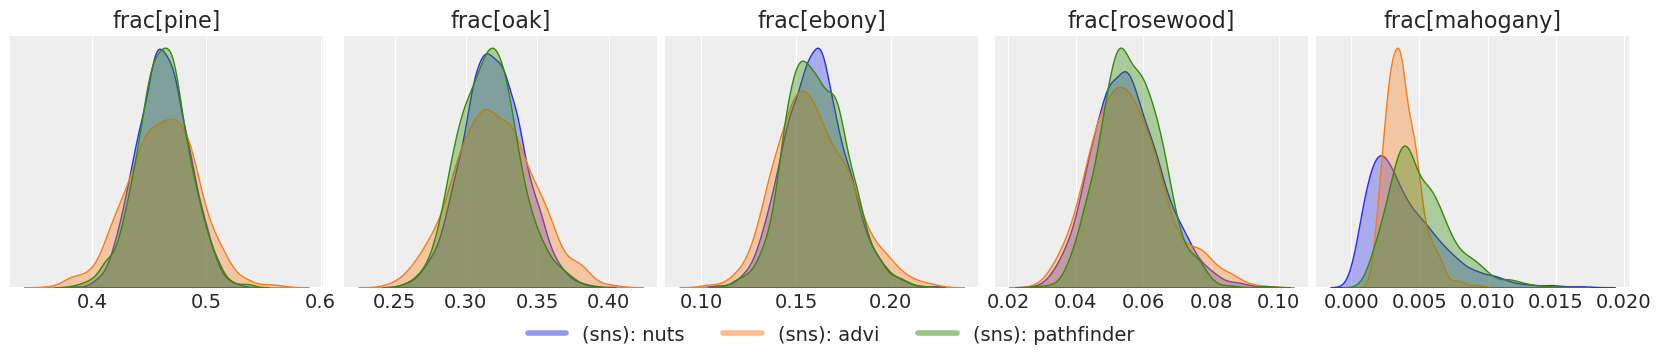

In [171]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res)

In [7]:
with pm.Model(coords=coords) as model_dm_explicit:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    p = pm.Dirichlet("p", a=frac * conc, dims=("forest", "tree"))
    counts = pm.Multinomial(
        "counts", n=total_count, p=p, observed=observed_counts, dims=("forest", "tree")
    )

In [173]:
with model_dm_explicit:
    print("Starting NUTS fit...")
    %timeit -r 5 pm.sample(chains=4, target_accept=0.9, progressbar=False)
    print("\nStarting ADVI fit...")
    %timeit -r 5 pm.fit(n=30_000, progressbar=False).sample(1000)
    print("\nStarting Pathfinder fit...")
    %timeit -r 5 pmx.fit(method="pathfinder")

Starting NUTS fit...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for detai

1min 11s ± 11.4 s per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 112.96
Finished [100%]: Average Loss = 112.81
Finished [100%]: Average Loss = 112.9
Finished [100%]: Average Loss = 112.83
Finished [100%]: Average Loss = 112.79
Finished [100%]: Average Loss = 112.76
Number of parameters: 45
Setting maxcor to 12


8.85 s ± 291 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

Starting Pathfinder fit...


Pareto k value: 1.68
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.51
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.48
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.30
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.81
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.47


5.32 s ± 78.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
with model_dm_explicit:
    idata_nuts = pm.sample(chains=4, target_accept=0.9, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_psir_pf = pmx.fit(
        method="pathfinder", importance_sampling="psir", random_seed=41
    )
    idata_pf = pmx.fit(method="pathfinder", random_seed=41)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Finished [100%]: Average Loss = 112.86
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.40
Number of parameters: 45
Setting maxcor to 12
Pareto k value: 1.40


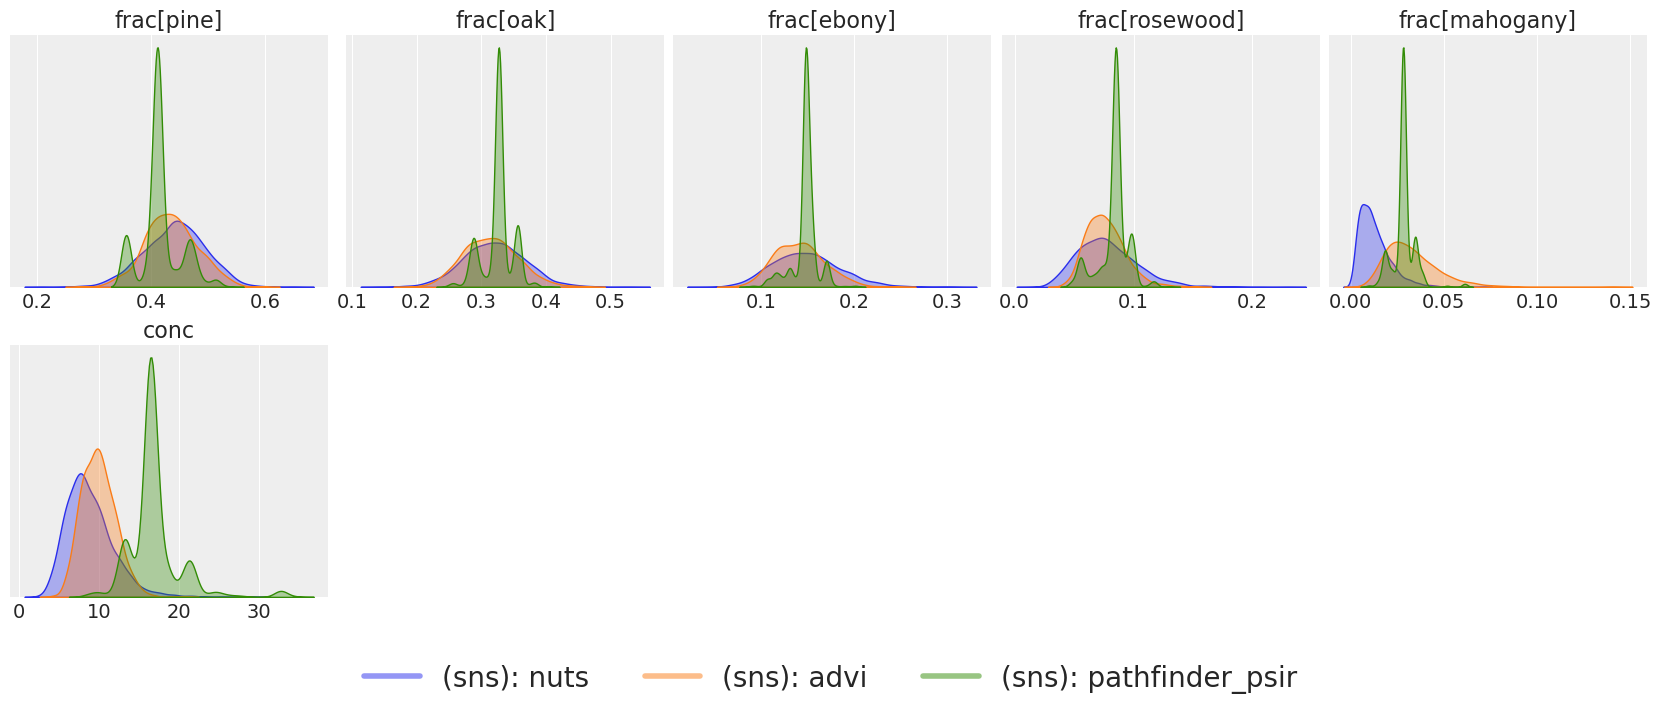

In [13]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder_psir": idata_psir_pf,
    # "pathfinder": idata_pf,
}
plot_results(
    res,
    var_names=["frac", "conc"],
)

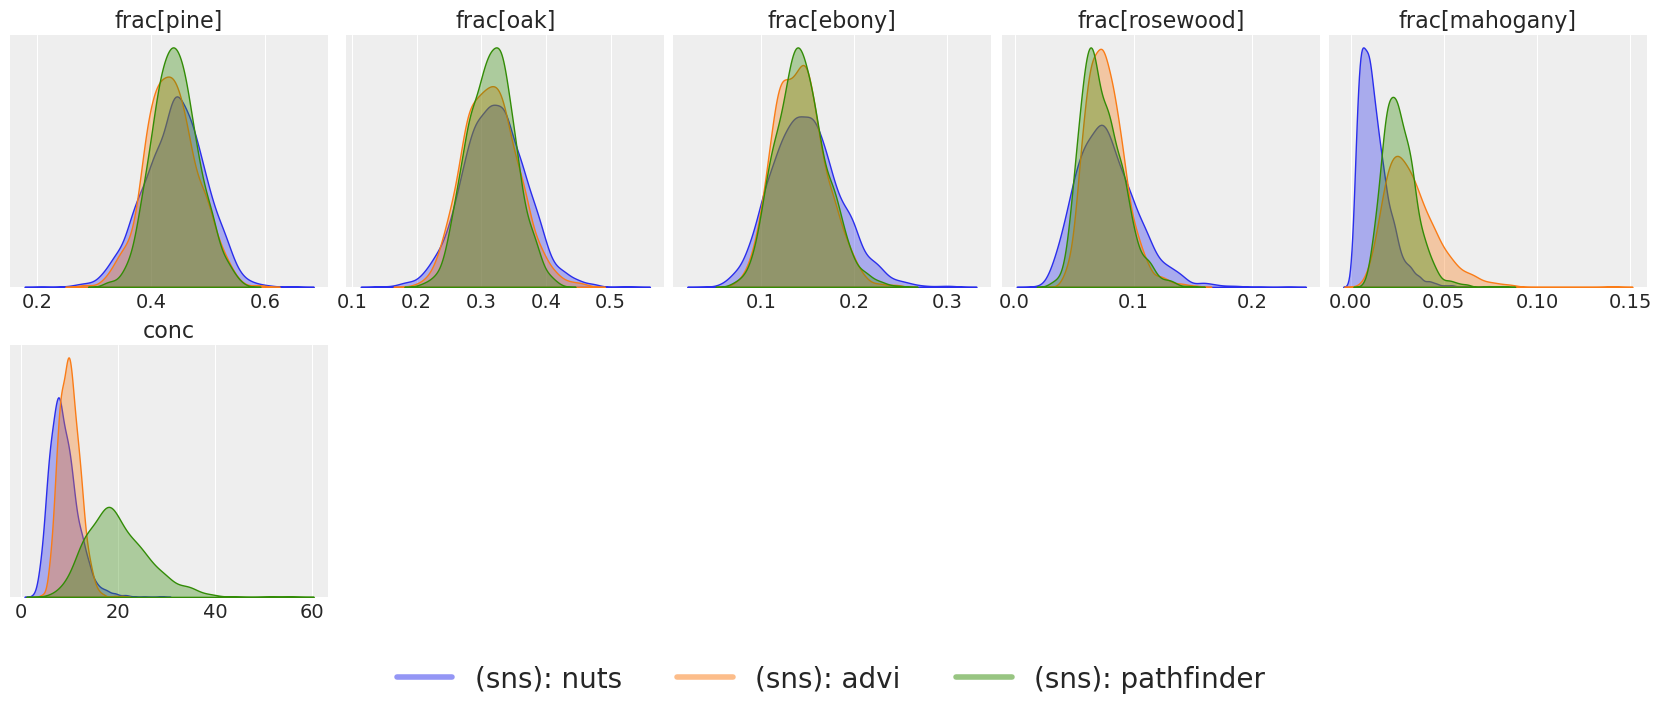

In [14]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    # "pathfinder_psir": idata_psir_pf,
    "pathfinder": idata_pf,
}
plot_results(
    res,
    var_names=["frac", "conc"],
)

In [71]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,pymc

Last updated: Mon Dec 09 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.28.0

pytensor: 2.26.4
pymc    : 5.19.1

pymc_experimental: 0.1.2
numpy            : 1.26.4
logging          : 0.5.1.2
pymc             : 5.19.1
packaging        : 24.2
seaborn          : 0.13.2
debugpy          : 1.8.7
ipykernel        : 6.29.5
arviz            : 0.20.0
pytensor         : 2.26.4
json             : 2.0.9
filelock         : 3.16.1
matplotlib       : 3.9.1
pandas           : 2.2.2
jax              : 0.4.35
blackjax         : 1.2.5.dev2+gb107f9fd.d20241026
scipy            : 1.14.1

Watermark: 2.4.3

